In [1]:
import uproot as up
import numpy as np
import time
import iminuit
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL
from iminuit.cost import UnbinnedNLL
from scipy.optimize import minimize
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
from multiprocessing import Pool
import multiprocessing

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"
sys.path.append('/software/pc24403/tfpcbpggsz/amp')
from PyD0ToKSpipi2018 import *

Kspipi = PyD0ToKSpipi2018()
Kspipi.init()
print('INFO: Loading the amplitude model')




Num GPUs Available:  6
INFO: Loading the amplitude model
D0ToKSpipi2018 ==> Initialization !


In [2]:
def get_mass(p1,p2):
    return ((p1[:,0]+p2[:,0])**2 - (p1[:,1]+p2[:,1])**2 - (p1[:,2]+p2[:,2])**2 - (p1[:,3]+p2[:,3])**2)


def get_p4(decay="b2dpi", cut='', index=2):

    file_name = ''
    branch_names = []
    if cut == 'int':
        file_name = f'/software/pc24403/PCBPGGSZ/Int/weighted_{decay}.root:DalitzEventList'
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
    
    elif decay.split('_')[0] == 'b2dk' or decay.split('_')[0] == 'b2dpi':
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz", "B_M"]
        if cut == 'p':
            #file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/add_sw/lhcb_toy_{decay}_{index}_CPrange.root:BplusDalitzEventList'
            file_name = f'/software/pc24403/tfpcbpggsz/example/b2dk_DD.root:Bplus_DalitzEventList'

        else:
            #file_name = f'/software/pc24403/PCBPGGSZ/outputs/oy/mass_fit/add_sw/lhcb_toy_{decay}_{index}.root:BminusDalitzEventList'
            file_name = f'/software/pc24403/tfpcbpggsz/example/b2dk_DD.root:Bminus_DalitzEventList'

    tree = up.open(file_name)
  # Load the branches as arrays
    
    array = tree.arrays(branch_names)
       

    _p1 = np.asarray([array["_1_K0S0_E"], array["_1_K0S0_Px"], array["_1_K0S0_Py"], array["_1_K0S0_Pz"]])
    _p2 = np.asarray([array["_2_pi#_E"], array["_2_pi#_Px"], array["_2_pi#_Py"], array["_2_pi#_Pz"]])
    _p3 = np.asarray([array["_3_pi~_E"], array["_3_pi~_Px"], array["_3_pi~_Py"], array["_3_pi~_Pz"]])
    
    # convert 4*1000 into a vectot<double>
    p1 = np.transpose(_p1)
    p2 = np.transpose(_p2)
    p3 = np.transpose(_p3)

    p1bar = np.hstack((p1[:, :1], np.negative(p1[:, 1:])))
    p2bar = np.hstack((p2[:, :1], np.negative(p2[:, 1:])))
    p3bar = np.hstack((p3[:, :1], np.negative(p3[:, 1:])))



    return p1, p2, p3, p1bar, p2bar, p3bar

def load_int_amp(args):
    p1, p2, p3 = args

    return Kspipi.Amp_PFT(p1.tolist(), p2.tolist(), p3.tolist())

def getAmp(decay='b2dpi', cut='int'):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar, B_M = get_p4_v2(decay=decay, cut=cut, comp='sig')
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    data = [(p1_np[i], p3_np[i], p2_np[i]) for i in range(len(p1_np))]
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        amplitude.append(pool.map(load_int_amp, data))
    data_bar = [(p1bar_np[i], p2bar_np[i], p3bar_np[i]) for i in range(len(p1bar_np))]
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        amplitudeBar.append(pool.map(load_int_amp, data_bar))
    
    end_time = time.time()
    print(f'Amplitude for {decay} loaded in {end_time-start_time} seconds')
    amplitude = np.array(amplitude)
    amplitudeBar = np.array(amplitudeBar)


    return amplitude, amplitudeBar
    
def get_p4_v2(decay="b2dpi", cut='', index=2, comp='sig'):

    file_name = ''
    branch_names = []
    if cut == 'int':
        file_name = f'/software/pc24403/PCBPGGSZ/Int/weighted_{decay}.root:DalitzEventList'
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
    
    elif decay.split('_')[0] == 'b2dk' or decay.split('_')[0] == 'b2dpi':
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz", "B_M"]
        if cut == 'p':
            #file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/add_sw/lhcb_toy_{decay}_{index}_CPrange.root:BplusDalitzEventList'
            file_name = f'/software/pc24403/tfpcbpggsz/example/b2dk_DD.root:Bplus_DalitzEventList'

        else:
            #file_name = f'/software/pc24403/PCBPGGSZ/outputs/oy/mass_fit/add_sw/lhcb_toy_{decay}_{index}.root:BminusDalitzEventList'
            file_name = f'/software/pc24403/tfpcbpggsz/example/b2dk_DD.root:Bminus_DalitzEventList'

    tree = up.open(file_name)
  # Load the branches as arrays
    
    array = tree.arrays(branch_names, '(B_M>5150) & (B_M<5800)')
       

    _p1 = np.asarray([array["_1_K0S0_E"], array["_1_K0S0_Px"], array["_1_K0S0_Py"], array["_1_K0S0_Pz"]])
    _p2 = np.asarray([array["_2_pi#_E"], array["_2_pi#_Px"], array["_2_pi#_Py"], array["_2_pi#_Pz"]])
    _p3 = np.asarray([array["_3_pi~_E"], array["_3_pi~_Px"], array["_3_pi~_Py"], array["_3_pi~_Pz"]])
    
    # convert 4*1000 into a vectot<double>
    p1 = np.transpose(_p1)
    p2 = np.transpose(_p2)
    p3 = np.transpose(_p3)

    p1bar = np.hstack((p1[:, :1], np.negative(p1[:, 1:])))
    p2bar = np.hstack((p2[:, :1], np.negative(p2[:, 1:])))
    p3bar = np.hstack((p3[:, :1], np.negative(p3[:, 1:])))

    B_M = np.zeros(len(p1))
    if cut != 'int':
        
        B_M = np.asarray([array["B_M"]])


    return p1, p2, p3, p1bar, p2bar, p3bar, B_M


def getMass(decay='b2dpi', cut='int'):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar = get_p4(decay=decay, cut=cut)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    s12 = get_mass(p1_np, p2_np)
    s13 = get_mass(p1_np, p3_np)

    return s12, s13

def getMass_v2(decay='b2dpi', cut='int', comp='sig'):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar, B_M = get_p4_v2(decay=decay, cut=cut, comp=comp)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    s12 = get_mass(p1_np, p2_np)
    s13 = get_mass(p1_np, p3_np)

    return s12, s13, B_M

In [3]:
sys.path.append('/software/pc24403/tfpcbpggsz/func')
sys.path.append('/software/pc24403/tfpcbpggsz/amp')

mc_path = '/shared/scratch/pc24403/amp'

amp_Data_dk_dd_p, ampbar_Data_dk_dd_p = getAmp('b2dk_DD', 'p')
amp_Data_dk_dd_m, ampbar_Data_dk_dd_m = getAmp('b2dk_DD', 'm')

amp_dk_dd_p = np.load(mc_path + '/Int_b2dk_DD_p_amp.npy')
ampbar_dk_dd_p = np.load(mc_path + '/Int_b2dk_DD_p_ampbar.npy')
amp_dk_dd_m = np.load(mc_path + '/Int_b2dk_DD_m_amp.npy')
ampbar_dk_dd_m = np.load(mc_path + '/Int_b2dk_DD_m_ampbar.npy')


Amplitude for b2dk_DD loaded in 1.5858330726623535 seconds
Amplitude for b2dk_DD loaded in 1.111175298690796 seconds


In [4]:
sys.path.append('/software/pc24403/tfpcbpggsz/func')
from massshape import *

def norm_pdf(pdf):
    norm_term = np.mean(pdf)
    return np.array(pdf/norm_term)

def preparePdf_data(Bu_M, varDict, mode='b2dk_LL'):
    '''
    Import constructed data sets and construct PDFs with RooFit functions.
    PDFs and data sets are saved together in a new RooWorkspace

    Args:
        configDict: a dictionary containing the values of PDF shape parameters
        year: which subset of data to fit, can be any single year of data taking,
              or 'Run1', 'Run2', 'All'.
    ''' 

    pdfList = {}

    print('--- Constructing signal pdfs...')
    varDict['DD_dk_Gauss_frac'] = 1 - varDict['DD_dk_Cruijff_frac']
    varDict['DD_dpi_Gauss_frac'] = 1- varDict['DD_dpi_Cruijff_frac']
    varDict['LL_dk_Gauss_frac'] = 1 - varDict['LL_dk_Cruijff_frac']
    varDict['LL_dpi_Gauss_frac'] = 1 - varDict['LL_dpi_Cruijff_frac']

    pdf_sig_Cruijff_DK_KsPiPi_DD  = lambda Bu_M: CruijffExtended(Bu_M, varDict['signal_mean'], varDict['sigma_dk_DD'], varDict['sigma_dk_DD'], varDict['DD_dk_Cruijff_alpha_L'], varDict['DD_dk_Cruijff_alpha_R'], varDict['Cruijff_beta'])
    pdf_sig_Gauss_DK_KsPiPi_DD    = lambda Bu_M: Gaussian(Bu_M, varDict['signal_mean'], varDict['sigma_dk_DD'])

    pdf_sig_Cruijff_DPi_KsPiPi_DD = lambda Bu_M: CruijffExtended(Bu_M, varDict['signal_mean'], varDict['sigma_dpi_DD'], varDict['sigma_dpi_DD'], varDict['DD_dpi_Cruijff_alpha_L'], varDict['DD_dpi_Cruijff_alpha_R'], varDict['Cruijff_beta'])
    pdf_sig_Gauss_DPi_KsPiPi_DD   = lambda Bu_M: Gaussian(Bu_M, varDict['signal_mean'], varDict['sigma_dpi_DD'])
    pdf_sig_Cruijff_DK_KsPiPi_LL  = lambda Bu_M: CruijffExtended(Bu_M, varDict['signal_mean'], varDict['sigma_dk_LL'], varDict['sigma_dk_LL'], varDict['LL_dk_Cruijff_alpha_L'], varDict['LL_dk_Cruijff_alpha_R'], varDict['Cruijff_beta'])
    pdf_sig_Gauss_DK_KsPiPi_LL    = lambda Bu_M: Gaussian(Bu_M, varDict['signal_mean'], varDict['sigma_dk_LL'])
    pdf_sig_Cruijff_DPi_KsPiPi_LL = lambda Bu_M: CruijffExtended(Bu_M, varDict['signal_mean'], varDict['sigma_dpi_LL'], varDict['sigma_dpi_LL'], varDict['LL_dpi_Cruijff_alpha_L'], varDict['LL_dpi_Cruijff_alpha_R'], varDict['Cruijff_beta'])
    pdf_sig_Gauss_DPi_KsPiPi_LL   = lambda Bu_M: Gaussian(Bu_M, varDict['signal_mean'], varDict['sigma_dpi_LL'])


    if mode == 'b2dk_LL':
        pdfList['sig'] = lambda Bu_M: (norm_pdf(pdf_sig_Cruijff_DK_KsPiPi_LL(Bu_M)) * varDict['LL_dk_Cruijff_frac'] +  norm_pdf(pdf_sig_Gauss_DK_KsPiPi_LL(Bu_M)) * varDict['LL_dk_Gauss_frac'])
    elif mode == 'b2dpi_LL':
        pdfList['sig'] = lambda Bu_M: (norm_pdf(pdf_sig_Cruijff_DPi_KsPiPi_LL(Bu_M)) * varDict['LL_dpi_Cruijff_frac'] +  norm_pdf(pdf_sig_Gauss_DPi_KsPiPi_LL(Bu_M)) *  varDict['LL_dpi_Gauss_frac'])
    elif mode == 'b2dk_DD':
        pdfList['sig'] = lambda Bu_M: (norm_pdf(pdf_sig_Cruijff_DK_KsPiPi_DD(Bu_M)) * varDict['DD_dk_Cruijff_frac'] +  norm_pdf(pdf_sig_Gauss_DK_KsPiPi_DD(Bu_M)) *  varDict['DD_dk_Gauss_frac'])
    elif mode == 'b2dpi_DD':
        pdfList['sig'] = lambda Bu_M: (norm_pdf(pdf_sig_Cruijff_DPi_KsPiPi_DD(Bu_M)) * varDict['DD_dpi_Cruijff_frac'] + norm_pdf(pdf_sig_Gauss_DPi_KsPiPi_DD(Bu_M)) * varDict['DD_dpi_Gauss_frac'])    
 

    print('--- Constructing misID pdfs...')
    pdf_misid_CB1_DK_KsPiPi_LL = lambda Bu_M: CBShape(Bu_M, varDict['LL_d2kspp_dpi_to_dk_misID_mean1'], varDict['LL_d2kspp_dpi_to_dk_misID_width1'], varDict['LL_d2kspp_dpi_to_dk_misID_alpha1'], varDict['LL_d2kspp_dpi_to_dk_misID_n1'])
    pdf_misid_CB2_DK_KsPiPi_LL = lambda Bu_M: CBShape(Bu_M, varDict['LL_d2kspp_dpi_to_dk_misID_mean1'], varDict['LL_d2kspp_dpi_to_dk_misID_width2'], varDict['LL_d2kspp_dpi_to_dk_misID_alpha2'], varDict['LL_d2kspp_dpi_to_dk_misID_n1'])
    pdf_misid_CB1_DK_KsPiPi_DD = lambda Bu_M: CBShape(Bu_M, varDict['DD_d2kspp_dpi_to_dk_misID_mean1'], varDict['DD_d2kspp_dpi_to_dk_misID_width1'], varDict['DD_d2kspp_dpi_to_dk_misID_alpha1'], varDict['DD_d2kspp_dpi_to_dk_misID_n1'])
    pdf_misid_CB2_DK_KsPiPi_DD = lambda Bu_M: CBShape(Bu_M, varDict['DD_d2kspp_dpi_to_dk_misID_mean1'], varDict['DD_d2kspp_dpi_to_dk_misID_width2'], varDict['DD_d2kspp_dpi_to_dk_misID_alpha2'], varDict['DD_d2kspp_dpi_to_dk_misID_n1'])
    if mode == 'b2dk_LL':
        pdfList['misid'] = lambda Bu_M: (norm_pdf(pdf_misid_CB1_DK_KsPiPi_LL(Bu_M)) * varDict['LL_d2kspp_dpi_to_dk_misID_frac1'] + norm_pdf(pdf_misid_CB2_DK_KsPiPi_LL(Bu_M)) * varDict['LL_d2kspp_dpi_to_dk_misID_frac2'])
    elif mode == 'b2dk_DD':
        pdfList['misid'] = lambda Bu_M: (norm_pdf(pdf_misid_CB1_DK_KsPiPi_DD(Bu_M)) * varDict['DD_d2kspp_dpi_to_dk_misID_frac1'] + norm_pdf(pdf_misid_CB2_DK_KsPiPi_DD(Bu_M)) * varDict['DD_d2kspp_dpi_to_dk_misID_frac2'])
    elif mode == 'b2dpi_LL':
        pdfList['misid'] = lambda Bu_M: (CBShape(Bu_M, varDict['LL_dk_to_dpi_misID_mean1'], varDict['LL_dk_to_dpi_misID_width1'], varDict['LL_dk_to_dpi_misID_alpha1'], varDict['LL_dk_to_dpi_misID_n1']))
    elif mode == 'b2dpi_DD':
        pdfList['misid'] = lambda Bu_M: (CBShape(Bu_M, varDict['DD_dk_to_dpi_misID_mean1'], varDict['DD_dk_to_dpi_misID_width1'], varDict['DD_dk_to_dpi_misID_alpha1'], varDict['DD_dk_to_dpi_misID_n1']))

    print('--- Constructing low-mass pdfs...')
    varDict['low_sigma_k_DD'] = varDict['low_sigma_pi_DD']/varDict['low_sigma_pi_over_k_ratio']
    varDict['low_sigma_k_LL'] = varDict['low_sigma_pi_LL']/varDict['low_sigma_pi_over_k_ratio']
    varDict['low_sigma_gamma_dk'] = varDict['low_sigma_gamma']/varDict['low_sigma_pi_over_k_ratio_gamma']

    # B2Dsth (missing pi)
    pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_LL = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dpi'], varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_pi_LL'], varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_DD = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dpi'], varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_pi_DD'], varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_LL  = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dpi'],  varDict['low_b_Bd_Dstarph_D0pi_dpi'],  varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_pi_LL'], varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_DD  = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dpi'],  varDict['low_b_Bd_Dstarph_D0pi_dpi'],  varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_pi_DD'], varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL  = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dk'],  varDict['low_b_Bu_Dstar0h_D0pi0_dk'],  varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_k_LL'],  varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD  = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dk'],  varDict['low_b_Bu_Dstar0h_D0pi0_dk'],  varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_k_DD'],  varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bd_Dstarph_D0pi_DK_KsPiPi_LL   = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dk'],   varDict['low_b_Bd_Dstarph_D0pi_dk'],   varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_k_LL'],  varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bd_Dstarph_D0pi_DK_KsPiPi_DD   = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dk'],   varDict['low_b_Bd_Dstarph_D0pi_dk'],   varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_k_DD'],  varDict['low_ratio_pi'], varDict['low_f_pi'])
    # DK misid
    pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dk'], varDict['low_b_Bu_Dstar0h_D0pi0_dk'], varDict['low_csi_pi'], varDict['m1pi_LL'], varDict['s1pi_LL'], varDict['m2pi_LL'], varDict['s2pi_LL'], varDict['m3pi_LL'], varDict['s3pi_LL'], varDict['m4pi_LL'], varDict['s4pi_LL'], varDict['f1pi_LL'], varDict['f2pi_LL'], varDict['f3pi_LL'])
    pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dk'], varDict['low_b_Bu_Dstar0h_D0pi0_dk'], varDict['low_csi_pi'], varDict['m1pi_DD'], varDict['s1pi_DD'], varDict['m2pi_DD'], varDict['s2pi_DD'], varDict['m3pi_DD'], varDict['s3pi_DD'], varDict['m4pi_DD'], varDict['s4pi_DD'], varDict['f1pi_DD'], varDict['f2pi_DD'], varDict['f3pi_DD'])
    pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_LL  = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dk'],  varDict['low_b_Bd_Dstarph_D0pi_dk'],  varDict['low_csi_pi'], varDict['m1pi_LL'], varDict['s1pi_LL'], varDict['m2pi_LL'], varDict['s2pi_LL'], varDict['m3pi_LL'], varDict['s3pi_LL'], varDict['m4pi_LL'], varDict['s4pi_LL'], varDict['f1pi_LL'], varDict['f2pi_LL'], varDict['f3pi_LL'])
    pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_DD  = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dk'],  varDict['low_b_Bd_Dstarph_D0pi_dk'],  varDict['low_csi_pi'], varDict['m1pi_DD'], varDict['s1pi_DD'], varDict['m2pi_DD'], varDict['s2pi_DD'], varDict['m3pi_DD'], varDict['s3pi_DD'], varDict['m4pi_DD'], varDict['s4pi_DD'], varDict['f1pi_DD'], varDict['f2pi_DD'], varDict['f3pi_DD'])
    # DPi misid
    pdf_low_misID_Bu_Dstar0h_D0pi0_DPi_KsPiPi_LL = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dpi'], varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['m1pi_pi_LL'], varDict['s1pi_pi_LL'], varDict['m2pi_pi_LL'], varDict['s2pi_pi_LL'], varDict['m3pi_pi_LL'], varDict['s3pi_pi_LL'], varDict['m4pi_pi_LL'], varDict['s4pi_pi_LL'], varDict['f1pi_pi_LL'], varDict['f2pi_pi_LL'], varDict['f3pi_pi_LL'])
    pdf_low_misID_Bu_Dstar0h_D0pi0_DPi_KsPiPi_DD = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dpi'], varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['m1pi_pi_DD'], varDict['s1pi_pi_DD'], varDict['m2pi_pi_DD'], varDict['s2pi_pi_DD'], varDict['m3pi_pi_DD'], varDict['s3pi_pi_DD'], varDict['m4pi_pi_DD'], varDict['s4pi_pi_DD'], varDict['f1pi_pi_DD'], varDict['f2pi_pi_DD'], varDict['f3pi_pi_DD'])
    pdf_low_misID_Bd_Dstarph_D0pi_DPi_KsPiPi_LL  = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dpi'],  varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['m1pi_pi_LL'], varDict['s1pi_pi_LL'], varDict['m2pi_pi_LL'], varDict['s2pi_pi_LL'], varDict['m3pi_pi_LL'], varDict['s3pi_pi_LL'], varDict['m4pi_pi_LL'], varDict['s4pi_pi_LL'], varDict['f1pi_pi_LL'], varDict['f2pi_pi_LL'], varDict['f3pi_pi_LL'])
    pdf_low_misID_Bd_Dstarph_D0pi_DPi_KsPiPi_DD  = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dpi'],  varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['m1pi_pi_DD'], varDict['s1pi_pi_DD'], varDict['m2pi_pi_DD'], varDict['s2pi_pi_DD'], varDict['m3pi_pi_DD'], varDict['s3pi_pi_DD'], varDict['m4pi_pi_DD'], varDict['s4pi_pi_DD'], varDict['f1pi_pi_DD'], varDict['f2pi_pi_DD'], varDict['f3pi_pi_DD'])
    # B2Dsth (missing photon) 
    pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_LL = lambda Bu_M: HILLdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dpi'], varDict['low_b_Bu_Dstar0h_D0gamma_dpi'], varDict['low_csi_gamma'], varDict['low_global_shift'], varDict['low_sigma_gamma'],    varDict['low_ratio_gamma'], varDict['low_f_gamma'])
    pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_DD = lambda Bu_M: HILLdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dpi'], varDict['low_b_Bu_Dstar0h_D0gamma_dpi'], varDict['low_csi_gamma'], varDict['low_global_shift'], varDict['low_sigma_gamma'],    varDict['low_ratio_gamma'], varDict['low_f_gamma'])
    pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL  = lambda Bu_M: HILLdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dk'],  varDict['low_b_Bu_Dstar0h_D0gamma_dk'],  varDict['low_csi_gamma'], varDict['low_global_shift'], varDict['low_sigma_gamma_dk'], varDict['low_ratio_gamma'], varDict['low_f_gamma'])
    pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD  = lambda Bu_M: HILLdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dk'],  varDict['low_b_Bu_Dstar0h_D0gamma_dk'],  varDict['low_csi_gamma'], varDict['low_global_shift'], varDict['low_sigma_gamma_dk'], varDict['low_ratio_gamma'], varDict['low_f_gamma'])
    # DK misid
    pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL = lambda Bu_M: HILLdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dk'], varDict['low_b_Bu_Dstar0h_D0gamma_dk'], varDict['low_csi_gamma'], varDict['m1ga'], varDict['s1ga'], varDict['m2ga'], varDict['s2ga'], varDict['m3ga'], varDict['s3ga'], varDict['m4ga'], varDict['s4ga'], varDict['f1ga'], varDict['f2ga'], varDict['f3ga'])
    pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD = lambda Bu_M: HILLdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dk'], varDict['low_b_Bu_Dstar0h_D0gamma_dk'], varDict['low_csi_gamma'], varDict['m1ga'], varDict['s1ga'], varDict['m2ga'], varDict['s2ga'], varDict['m3ga'], varDict['s3ga'], varDict['m4ga'], varDict['s4ga'], varDict['f1ga'], varDict['f2ga'], varDict['f3ga'])
    # DPi misid
    pdf_low_misID_Bu_Dstar0h_D0gamma_DPi_KsPiPi_LL = lambda Bu_M: ßHILLdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dpi'], varDict['low_b_Bu_Dstar0h_D0gamma_dpi'], varDict['low_csi_gamma'], varDict['m1ga_pi'], varDict['s1ga_pi'], varDict['m2ga_pi'], varDict['s2ga_pi'], varDict['m3ga_pi'], varDict['s3ga_pi'], varDict['m4ga_pi'], varDict['s4ga_pi'], varDict['f1ga_pi'], varDict['f2ga_pi'], varDict['f3ga_pi'])
    pdf_low_misID_Bu_Dstar0h_D0gamma_DPi_KsPiPi_DD = lambda Bu_M: ßHILLdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dpi'], varDict['low_b_Bu_Dstar0h_D0gamma_dpi'], varDict['low_csi_gamma'], varDict['m1ga_pi'], varDict['s1ga_pi'], varDict['m2ga_pi'], varDict['s2ga_pi'], varDict['m3ga_pi'], varDict['s3ga_pi'], varDict['m4ga_pi'], varDict['s4ga_pi'], varDict['f1ga_pi'], varDict['f2ga_pi'], varDict['f3ga_pi'])

    # B2Dhpi
    # DPi
    pdf_B2Dpipi_1_DPi_KsPiPi_LL = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_I_B2Dpipi'],  varDict['low_b_I_B2Dpipi'],  varDict['low_csi_B2Dpipi'], varDict['low_global_shift'], varDict['low_sigma_I_B2Dpipi'],  varDict['low_ratio_B2Dpipi'], varDict['low_f_B2Dpipi'])
    pdf_B2Dpipi_1_DPi_KsPiPi_DD = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_I_B2Dpipi'],  varDict['low_b_I_B2Dpipi'],  varDict['low_csi_B2Dpipi'], varDict['low_global_shift'], varDict['low_sigma_I_B2Dpipi'],  varDict['low_ratio_B2Dpipi'], varDict['low_f_B2Dpipi'])
    pdf_B2Dpipi_2_DPi_KsPiPi_LL = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_II_B2Dpipi'], varDict['low_b_II_B2Dpipi'], varDict['low_csi_B2Dpipi'], varDict['low_global_shift'], varDict['low_sigma_II_B2Dpipi'], varDict['low_ratio_B2Dpipi'], varDict['low_f_B2Dpipi'])
    pdf_B2Dpipi_2_DPi_KsPiPi_DD = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_II_B2Dpipi'], varDict['low_b_II_B2Dpipi'], varDict['low_csi_B2Dpipi'], varDict['low_global_shift'], varDict['low_sigma_II_B2Dpipi'], varDict['low_ratio_B2Dpipi'], varDict['low_f_B2Dpipi'])
    pdf_B2Dpipi_DPi_KsPiPi_LL   = lambda Bu_M: pdf_B2Dpipi_1_DPi_KsPiPi_LL(Bu_M) * varDict['low_frac_B2Dpipi'] + pdf_B2Dpipi_2_DPi_KsPiPi_LL(Bu_M) * (1- varDict['low_frac_B2Dpipi'])
    pdf_B2Dpipi_DPi_KsPiPi_DD   = lambda Bu_M: pdf_B2Dpipi_1_DPi_KsPiPi_DD(Bu_M) * varDict['low_frac_B2Dpipi'] + pdf_B2Dpipi_2_DPi_KsPiPi_DD(Bu_M) * (1- varDict['low_frac_B2Dpipi'])
    # DK
    pdf_B2DKpi_1_DK_KsPiPi_LL = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_B2DKpi'], varDict['low_b_B2DKpi'], varDict['low_csi_B2DKpi'], varDict['low_global_shift'], varDict['low_sigma_B2DKpi'], varDict['low_ratio_B2DKpi'], varDict['low_f_B2DKpi'])
    pdf_B2DKpi_1_DK_KsPiPi_DD = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_B2DKpi'], varDict['low_b_B2DKpi'], varDict['low_csi_B2DKpi'], varDict['low_global_shift'], varDict['low_sigma_B2DKpi'], varDict['low_ratio_B2DKpi'], varDict['low_f_B2DKpi'])
    pdf_B2DKpi_2_DK_KsPiPi_LL = lambda Bu_M: Gaussian(Bu_M, varDict['low_mu_B2DKpi'], varDict['low_sigma_gaus_B2DKpi'])
    pdf_B2DKpi_2_DK_KsPiPi_DD = lambda Bu_M: Gaussian(Bu_M, varDict['low_mu_B2DKpi'], varDict['low_sigma_gaus_B2DKpi'])
    pdf_B2DKpi_DK_KsPiPi_LL   = lambda Bu_M: pdf_B2DKpi_1_DK_KsPiPi_LL(Bu_M) * varDict['low_frac_B2DKpi'] + pdf_B2DKpi_2_DK_KsPiPi_LL(Bu_M) * (1- varDict['low_frac_B2DKpi'])
    pdf_B2DKpi_DK_KsPiPi_DD   = lambda Bu_M: pdf_B2DKpi_1_DK_KsPiPi_DD(Bu_M) * varDict['low_frac_B2DKpi'] + pdf_B2DKpi_2_DK_KsPiPi_DD(Bu_M) * (1- varDict['low_frac_B2DKpi'])
    # DK misid
    pdf_low_misID_B2Dpipi_DK_KsPiPi_LL = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_B2Dpipi_misID'], varDict['low_b_B2Dpipi_misID'], varDict['low_csi_B2Dpipi'], varDict['low_m1_B2Dpipi_misID'], varDict['low_s1_B2Dpipi_misID'], varDict['low_m2_B2Dpipi_misID'], varDict['low_s2_B2Dpipi_misID'], varDict['low_m3_B2Dpipi_misID'], varDict['low_s3_B2Dpipi_misID'], varDict['low_m4_B2Dpipi_misID'], varDict['low_s4_B2Dpipi_misID'], varDict['low_f1_B2Dpipi_misID'], varDict['low_f2_B2Dpipi_misID'], varDict['low_f3_B2Dpipi_misID'])
    pdf_low_misID_B2Dpipi_DK_KsPiPi_DD = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_B2Dpipi_misID'], varDict['low_b_B2Dpipi_misID'], varDict['low_csi_B2Dpipi'], varDict['low_m1_B2Dpipi_misID'], varDict['low_s1_B2Dpipi_misID'], varDict['low_m2_B2Dpipi_misID'], varDict['low_s2_B2Dpipi_misID'], varDict['low_m3_B2Dpipi_misID'], varDict['low_s3_B2Dpipi_misID'], varDict['low_m4_B2Dpipi_misID'], varDict['low_s4_B2Dpipi_misID'], varDict['low_f1_B2Dpipi_misID'], varDict['low_f2_B2Dpipi_misID'], varDict['low_f3_B2Dpipi_misID'])

    # Bs pdf
    pdf_low_Bs2DKPi_DK_KsPiPi_LL = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bs2DKpi'], varDict['low_b_Bs2DKpi'], varDict['low_csi_Bs2DKpi'], varDict['low_global_shift'], varDict['low_sigma_Bs2DKpi'], varDict['low_ratio_Bs2DKpi'], varDict['low_f_Bs2DKpi'])
    pdf_low_Bs2DKPi_DK_KsPiPi_DD = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bs2DKpi'], varDict['low_b_Bs2DKpi'], varDict['low_csi_Bs2DKpi'], varDict['low_global_shift'], varDict['low_sigma_Bs2DKpi'], varDict['low_ratio_Bs2DKpi'], varDict['low_f_Bs2DKpi'])

    if mode == 'b2dk_LL':
        pdfList['low_Bs2DKPi'] = lambda Bu_M: (pdf_low_Bs2DKPi_DK_KsPiPi_LL(Bu_M))
    elif mode == 'b2dk_DD':
        pdfList['low_Bs2DKPi'] = lambda Bu_M: norm_pdf(pdf_low_Bs2DKPi_DK_KsPiPi_DD(Bu_M))


    # Combine: with fractions
    if 'frac_low_Bu_Dstar0h_D0pi0_DPi' in varDict.keys():
        # Combine: DPi lowmass
        pdf_low_dpi_DPi_KsPiPi_LL = lambda Bu_M: varDict['frac_low_Bu_Dstar0h_D0pi0_DPi']*norm_pdf(pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_LL(Bu_M)) + varDict['frac_low_Bd_Dstarph_D0pi_DPi']* norm_pdf(pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_LL(Bu_M)) + varDict['frac_low_Bu_Dstar0h_D0gamma_DPi'] * norm_pdf(pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_LL(Bu_M)) + varDict['frac_low_B2Dpipi_DPi'] * norm_pdf(pdf_B2Dpipi_DPi_KsPiPi_LL(Bu_M))
        pdf_low_dpi_DPi_KsPiPi_DD = lambda Bu_M: varDict['frac_low_Bu_Dstar0h_D0pi0_DPi']*norm_pdf(pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_DD(Bu_M)) + varDict['frac_low_Bd_Dstarph_D0pi_DPi']* norm_pdf(pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_DD(Bu_M)) + varDict['frac_low_Bu_Dstar0h_D0gamma_DPi'] * norm_pdf(pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_DD(Bu_M)) + varDict['frac_low_B2Dpipi_DPi'] * norm_pdf(pdf_B2Dpipi_DPi_KsPiPi_DD(Bu_M))
        # Combine: DK lowmass
        pdf_low_dk_DK_KsPiPi_LL = lambda Bu_M: varDict['frac_low_Bu_Dstar0h_D0pi0_DK']*norm_pdf(pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL(Bu_M)) + varDict['frac_low_Bd_Dstarph_D0pi_DK']* norm_pdf(pdf_Bd_Dstarph_D0pi_DK_KsPiPi_LL(Bu_M)) + varDict['frac_low_Bu_Dstar0h_D0gamma_DK']* norm_pdf(pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL(Bu_M)) + varDict['frac_low_B2DKpi_DK']* norm_pdf(pdf_B2DKpi_DK_KsPiPi_LL(Bu_M))

        pdf_low_dk_DK_KsPiPi_DD = lambda Bu_M: varDict['frac_low_Bu_Dstar0h_D0pi0_DK']*norm_pdf(pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD(Bu_M)) + varDict['frac_low_Bd_Dstarph_D0pi_DK']* norm_pdf(pdf_Bd_Dstarph_D0pi_DK_KsPiPi_DD(Bu_M)) + varDict['frac_low_Bu_Dstar0h_D0gamma_DK'] * norm_pdf(pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD(Bu_M)) + varDict['frac_low_B2DKpi_DK']* norm_pdf(pdf_B2DKpi_DK_KsPiPi_DD(Bu_M))
        # Combine: DK misid
        pdf_low_misID_DK_KsPiPi_LL = lambda Bu_M: varDict['frac_low_misID_Bu_Dstar0h_D0pi0_DK']* norm_pdf(pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL(Bu_M)) + varDict['frac_low_misID_Bd_Dstarph_D0pi_DK']* norm_pdf(pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_LL(Bu_M)) + varDict['frac_low_misID_Bu_Dstar0h_D0gamma_DK']* norm_pdf(pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL(Bu_M)) + varDict['frac_low_misID_B2Dpipi_DK']* norm_pdf(pdf_low_misID_B2Dpipi_DK_KsPiPi_LL(Bu_M))
        pdf_low_misID_DK_KsPiPi_DD = lambda Bu_M: varDict['frac_low_misID_Bu_Dstar0h_D0pi0_DK']* norm_pdf(pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD(Bu_M)) + varDict['frac_low_misID_Bd_Dstarph_D0pi_DK']* norm_pdf(pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_DD(Bu_M)) + varDict['frac_low_misID_Bu_Dstar0h_D0gamma_DK']* norm_pdf(pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD(Bu_M)) + varDict['frac_low_misID_B2Dpipi_DK']* norm_pdf(pdf_low_misID_B2Dpipi_DK_KsPiPi_DD(Bu_M))
    # Combine: with ratios
    else:
        # Combine: DPi lowmass
        pdf_low_dst2dpi_DPi_KsPiPi_LL = addPdf([pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_LL, pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_LL], varDict['low_dpi_ratio_Bd_dst_vs_Bu_dst'])
        pdf_low_dst2dpi_DPi_KsPiPi_DD = addPdf([pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_DD, pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_DD], varDict['low_dpi_ratio_Bd_dst_vs_Bu_dst'])
        pdf_low_dpi_dst_DPi_KsPiPi_LL = addPdf([pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_LL, pdf_low_dst2dpi_DPi_KsPiPi_LL], varDict['low_dpi_ratio_dst2dgam_vs_dst2dpi'])
        pdf_low_dpi_dst_DPi_KsPiPi_DD = addPdf([pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_DD, pdf_low_dst2dpi_DPi_KsPiPi_DD], varDict['low_dpi_ratio_dst2dgam_vs_dst2dpi'])
        pdf_low_dpi_DPi_KsPiPi_LL     = addPdf([pdf_B2Dpipi_DPi_KsPiPi_LL, pdf_low_dpi_dst_DPi_KsPiPi_LL], varDict['low_dpi_ratio_b2drho_vs_b2dstpi'])
        pdf_low_dpi_DPi_KsPiPi_DD     = addPdf([pdf_B2Dpipi_DPi_KsPiPi_DD, pdf_low_dpi_dst_DPi_KsPiPi_DD], varDict['low_dpi_ratio_b2drho_vs_b2dstpi'])
        # Combine: DK lowmass
        pdf_low_dst2dpi_DK_KsPiPi_LL = addPdf([pdf_Bd_Dstarph_D0pi_DK_KsPiPi_LL, pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL], varDict['low_dk_ratio_Bd_dst_vs_Bu_dst']) 
        pdf_low_dst2dpi_DK_KsPiPi_DD = addPdf([pdf_Bd_Dstarph_D0pi_DK_KsPiPi_DD, pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD], varDict['low_dk_ratio_Bd_dst_vs_Bu_dst']) 
        pdf_low_dk_dst_DK_KsPiPi_LL  = addPdf([pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL, pdf_low_dst2dpi_DK_KsPiPi_LL], varDict['low_dk_ratio_dst2dgam_vs_dst2dk'])
        pdf_low_dk_dst_DK_KsPiPi_DD  = addPdf([pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD, pdf_low_dst2dpi_DK_KsPiPi_DD], varDict['low_dk_ratio_dst2dgam_vs_dst2dk'])
        pdf_low_dk_DK_KsPiPi_LL      = addPdf([pdf_B2DKpi_DK_KsPiPi_LL, pdf_low_dk_dst_DK_KsPiPi_LL], varDict['low_dk_ratio_b2dkst_vs_b2dstk'])
        pdf_low_dk_DK_KsPiPi_DD      = addPdf([pdf_B2DKpi_DK_KsPiPi_DD, pdf_low_dk_dst_DK_KsPiPi_DD], varDict['low_dk_ratio_b2dkst_vs_b2dstk'])
        # Combine: DK misid
        pdf_low_misID_dst2dpi_DK_KsPiPi_LL = addPdf([pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_LL, pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL], varDict['low_dpi_to_dk_misID_ratio_Bd_dst_vs_Bu_dst'])
        pdf_low_misID_dst2dpi_DK_KsPiPi_DD = addPdf([pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_DD, pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD], varDict['low_dpi_to_dk_misID_ratio_Bd_dst_vs_Bu_dst'])
        pdf_low_misID_dst_DK_KsPiPi_LL     = addPdf([pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL, pdf_low_misID_dst2dpi_DK_KsPiPi_LL], varDict['low_dpi_to_dk_misID_ratio_dst2dgam_vs_dst2dpi'])
        pdf_low_misID_dst_DK_KsPiPi_DD     = addPdf([pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD, pdf_low_misID_dst2dpi_DK_KsPiPi_DD], varDict['low_dpi_to_dk_misID_ratio_dst2dgam_vs_dst2dpi'])
        pdf_low_misID_DK_KsPiPi_LL         = addPdf([pdf_low_misID_B2Dpipi_DK_KsPiPi_LL, pdf_low_misID_dst_DK_KsPiPi_LL], varDict['low_dpi_to_dk_misID_ratio_b2drho_vs_b2dstpi'])
        pdf_low_misID_DK_KsPiPi_DD         = addPdf([pdf_low_misID_B2Dpipi_DK_KsPiPi_DD, pdf_low_misID_dst_DK_KsPiPi_DD], varDict['low_dpi_to_dk_misID_ratio_b2drho_vs_b2dstpi'])

    if mode == 'b2dk_LL':
        pdfList['low'] = lambda Bu_M: (pdf_low_dk_DK_KsPiPi_LL(Bu_M))
        pdfList['low_misID'] = lambda Bu_M: (pdf_low_misID_DK_KsPiPi_LL(Bu_M))

    elif mode == 'b2dk_DD':
        pdfList['low'] = lambda Bu_M: (pdf_low_dk_DK_KsPiPi_DD(Bu_M))
        pdfList['low_misID'] = lambda Bu_M: (pdf_low_misID_DK_KsPiPi_DD(Bu_M))

    elif mode == 'dpi_LL':
        pdfList['low'] = lambda Bu_M: (pdf_low_dpi_DPi_KsPiPi_LL(Bu_M))

    elif mode == 'dpi_DD':
        pdfList['low'] = lambda Bu_M: (pdf_low_dpi_DPi_KsPiPi_DD(Bu_M))


    # combinatorial
    print('--- Constructing comb pdfs...')
    if mode == 'b2dk_LL':
        pdfList['comb'] = lambda Bu_M: norm_pdf(Exponential(Bu_M, varDict['comb_const_dk_d2kspp_LL']))
    elif mode == 'b2dk_DD':
        pdfList['comb'] = lambda Bu_M: norm_pdf(Exponential(Bu_M, varDict['comb_const_dk_d2kspp_DD']))
    elif mode == 'dpi_LL':
        pdfList['comb'] = lambda Bu_M: norm_pdf(Exponential(Bu_M, varDict['comb_const_dpi_d2kspp_LL']))
    elif mode == 'dpi_DD':
        pdfList['comb'] = lambda Bu_M: norm_pdf(Exponential(Bu_M, varDict['comb_const_dpi_d2kspp_DD']))


    print('--- INFO: Writing to file...')
    return pdfList

In [5]:
from importlib.machinery import SourceFileLoader

config_mass_shape_output = SourceFileLoader('config_mass_shape_output', '/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/config/lhcb/%s'%('config_cpfit_output_2.py')).load_module()
varDict = config_mass_shape_output.getconfig()

sig_yield = {}
misid_yield = {}
Bdecays = ['b2dk']
Types = ['LL', 'DD']
for bdecay in Bdecays:
    for Type in Types:
        decay = ''

        if bdecay == 'b2dk':
            decay = 'DK_KsPiPi_%s'%Type
        elif bdecay == 'b2dpi':
            decay = 'DPi_KsPiPi_%s'%Type

        #print yields
        print('Yields:')
        print('Sig: %.2f'%varDict['n_sig_%s'%decay])
        print('MisID: %.2f'%varDict['n_misid_%s'%decay])
        print('Low: %.2f'%varDict['n_low_%s'%decay])
        print('Comb: %.2f'%varDict['n_comb_%s'%decay])
        print('Low MisID: %.2f'%varDict['n_low_misID_%s'%decay])
        print('Low Bs2DKPi: %.2f'%varDict['n_low_Bs2DKPi_%s'%decay])
        sum_yields = varDict['n_sig_%s'%decay] + varDict['n_misid_%s'%decay] + varDict['n_low_%s'%decay] + varDict['n_comb_%s'%decay] + varDict['n_low_misID_%s'%decay] + varDict['n_low_Bs2DKPi_%s'%decay]
        print('Sum: %.2f'%sum_yields)
        
        sig_yield[bdecay+Type] = varDict['n_sig_%s'%decay]
        misid_yield[bdecay+Type] = varDict['n_misid_%s'%decay]

Yields:
Sig: 4690.60
MisID: 1819.14
Low: 236.56
Comb: 1438.49
Low MisID: 1106.10
Low Bs2DKPi: 114.08
Sum: 9404.98
Yields:
Sig: 10706.31
MisID: 4019.96
Low: 434.39
Comb: 2965.24
Low MisID: 2515.03
Low Bs2DKPi: 257.70
Sum: 20898.64


In [6]:
pdfs_data = {}
s12_data = {}
s13_data = {}
Bu_M = {}
for decay in ['b2dk_DD']:
    for charge in ['p', 'm']:
        new_decay = decay + '_'+ charge
        print('--- INFO: Preparing pdfs for %s...'%new_decay)
        s12_data[new_decay], s13_data[new_decay], Bu_M[new_decay] = getMass_v2(decay, charge)
        pdfs_data[new_decay] = preparePdf_data(Bu_M[new_decay], varDict, decay)

    Bu_M[decay] = np.concatenate((Bu_M[decay+'_p'].flatten(), Bu_M[decay+'_m'].flatten()))
    pdfs_data[decay] = preparePdf_data(Bu_M[decay], varDict, decay)


--- INFO: Preparing pdfs for b2dk_DD_p...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- INFO: Preparing pdfs for b2dk_DD_m...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...


In [7]:
pdfs_data['b2dk_DD']

{'sig': <function __main__.preparePdf_data.<locals>.<lambda>(Bu_M)>,
 'misid': <function __main__.preparePdf_data.<locals>.<lambda>(Bu_M)>,
 'low_Bs2DKPi': <function __main__.preparePdf_data.<locals>.<lambda>(Bu_M)>,
 'low': <function __main__.preparePdf_data.<locals>.<lambda>(Bu_M)>,
 'low_misID': <function __main__.preparePdf_data.<locals>.<lambda>(Bu_M)>,
 'comb': <function __main__.preparePdf_data.<locals>.<lambda>(Bu_M)>}

In [8]:
%%time


def nll_extended(par):
    decay = 'b2dk_DD'
    x= Bu_M[decay]
    nsig = par[0]
    nmisid = par[1]
    pdf = pdfs_data['b2dk_DD']['sig']
    pdf2 = pdfs_data['b2dk_DD']['misid']
    ntotal = nsig + nmisid

    npdf = nsig*pdf(x) + nmisid*pdf2(x)
    altpdf = npdf/ntotal


    nll = - 2 * (sum(np.log(npdf)) - ntotal)
    
    print(nll)
    return nll

nll_extended.errordef = Minuit.LIKELIHOOD
ntotal = 10000
nsig = 5000
nmisid = 0
bounds = [(0, 12000), (0, 12000)]
x=[nsig, nmisid]

model = minimize(nll_extended, x, method="L-BFGS-B", bounds=bounds)


-210592.5918579408
-210592.59185797925
-210592.5918612578
-228715.10417011083
-228715.10417013467
-228715.104170307
-229120.58384132723
-229120.58384135057
-229120.5838415132
-230557.2909091989
-230557.2909092205
-230557.29090935196
-234980.152893829
-234980.1528938496
-234980.15289391496
-238718.06468293723
-238718.06468295425
-238718.06468298865
-242586.90157744868
-242586.90157746163
-242586.90157747726
-245839.7790363517
-245839.779036359
-245839.77903636626
-247519.1012194292
-247519.10121943132
-247519.10121943377
-247843.39080327546
-247843.3908032753
-247843.39080327892
-247988.4385703093
-247988.4385703083
-247988.43857030725
-247973.59488368893
-247973.59488369012
-247973.5948836911
-247990.12475769527
-247990.124757695
-247990.12475769402
-247977.22061846597
-247977.22061846676
-247977.22061846618
-247989.17428390044
-247989.17428390126
-247989.17428389943
-247990.00635323097
-247990.00635323103
-247990.00635323153
-247990.08719456597
-247990.08719456565
-247990.08719456525


In [9]:
minimized_nsig = model.x[0]
minimized_nmisid = model.x[1]


In [10]:
x_exp = (varDict['n_sig_DK_KsPiPi_DD']/2, varDict['n_misid_DK_KsPiPi_DD']/2, varDict['n_comb_DK_KsPiPi_DD']/2, varDict['n_low_DK_KsPiPi_DD']/2, varDict['n_low_misID_DK_KsPiPi_DD']/2, varDict['n_low_Bs2DKPi_DK_KsPiPi_DD']/2)
print('nsig: %.2f'%minimized_nsig)
print('nmisid: %.2f'%minimized_nmisid)
print('ntotal: %.2f'%(minimized_nsig+minimized_nmisid))
print('nsig: %.2f'%x_exp[0])
print('nmisid: %.2f'%x_exp[1])
print('ntotal: %.2f'%(x_exp[0]+x_exp[1]))


nsig: 8731.04
nmisid: 5871.61
ntotal: 14602.65
nsig: 5353.16
nmisid: 2009.98
ntotal: 7363.14


In [11]:
def get_mass(p1,p2):
    return ((p1[:,0]+p2[:,0])**2 - (p1[:,1]+p2[:,1])**2 - (p1[:,2]+p2[:,2])**2 - (p1[:,3]+p2[:,3])**2)


def get_p4(decay="b2dpi", cut='', index=2):

    file_name = ''
    branch_names = []
    if cut == 'int':
        file_name = f'/software/pc24403/PCBPGGSZ/Int/weighted_{decay}.root:DalitzEventList'
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
    
    elif decay.split('_')[0] == 'b2dk' or decay.split('_')[0] == 'b2dpi':
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
        if cut == 'p':
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/add_sw/new_frac_sw_pg/lhcb_toy_{decay}_{index}_CPrange.root:Bplus_DalitzEventList'
            #file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x_test/{decay}_sig_{index}.root:Bplus_DalitzEventList'

        else:
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/add_sw/new_frac_sw_pg/lhcb_toy_{decay}_{index}_CPrange.root:Bminus_DalitzEventList'
            #file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x_test/{decay}_sig_{index}.root:Bminus_DalitzEventList'

    tree = up.open(file_name)
  # Load the branches as arrays
    
    array = tree.arrays(branch_names)
       

    _p1 = np.asarray([array["_1_K0S0_E"], array["_1_K0S0_Px"], array["_1_K0S0_Py"], array["_1_K0S0_Pz"]])
    _p2 = np.asarray([array["_2_pi#_E"], array["_2_pi#_Px"], array["_2_pi#_Py"], array["_2_pi#_Pz"]])
    _p3 = np.asarray([array["_3_pi~_E"], array["_3_pi~_Px"], array["_3_pi~_Py"], array["_3_pi~_Pz"]])
    
    # convert 4*1000 into a vectot<double>
    p1 = np.transpose(_p1)
    p2 = np.transpose(_p2)
    p3 = np.transpose(_p3)

    p1bar = np.hstack((p1[:, :1], np.negative(p1[:, 1:])))
    p2bar = np.hstack((p2[:, :1], np.negative(p2[:, 1:])))
    p3bar = np.hstack((p3[:, :1], np.negative(p3[:, 1:])))



    return p1, p2, p3, p1bar, p2bar, p3bar

def load_int_amp(args):
    p1, p2, p3 = args

    return Kspipi.Amp_PFT(p1.tolist(), p2.tolist(), p3.tolist())

def getAmp(decay='b2dpi', cut='int'):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar = get_p4(decay=decay, cut=cut)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    data = [(p1_np[i], p3_np[i], p2_np[i]) for i in range(len(p1_np))]
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        amplitude.append(pool.map(load_int_amp, data))
    data_bar = [(p1bar_np[i], p2bar_np[i], p3bar_np[i]) for i in range(len(p1bar_np))]
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        amplitudeBar.append(pool.map(load_int_amp, data_bar))
    
    end_time = time.time()
    print(f'Amplitude for {decay} loaded in {end_time-start_time} seconds')
    amplitude = np.array(amplitude)
    amplitudeBar = np.array(amplitudeBar)

    return amplitude, amplitudeBar
    
def get_p4_v2(decay="b2dpi", cut='', index=2, comp='sig'):

    file_name = ''
    branch_names = []
    if cut == 'int':
        file_name = f'/software/pc24403/PCBPGGSZ/Int/weighted_{decay}.root:DalitzEventList'
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
    
    elif decay.split('_')[0] == 'b2dk' or decay.split('_')[0] == 'b2dpi':
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz", "B_M"]
        if cut == 'p':
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/add_sw/new_frac_sw_pg/{decay}_{index}_CPrange.root:DalitzEventList'
#            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_{comp}_{index}.root:Bplus_DalitzEventList'

        else:
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/add_sw/new_frac_sw_pg/{decay}_{index}_CPrange.root:DalitzEventList'
#            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_{comp}_{index}.root:Bminus_DalitzEventList'

    tree = up.open(file_name)
  # Load the branches as arrays
    charge = '(Bac_ID>0)'
    if cut == 'm':
        charge = '(Bac_ID<0)'
    
    array = tree.arrays(branch_names, charge)
       

    _p1 = np.asarray([array["_1_K0S0_E"], array["_1_K0S0_Px"], array["_1_K0S0_Py"], array["_1_K0S0_Pz"]])
    _p2 = np.asarray([array["_2_pi#_E"], array["_2_pi#_Px"], array["_2_pi#_Py"], array["_2_pi#_Pz"]])
    _p3 = np.asarray([array["_3_pi~_E"], array["_3_pi~_Px"], array["_3_pi~_Py"], array["_3_pi~_Pz"]])
    
    # convert 4*1000 into a vectot<double>
    p1 = np.transpose(_p1)
    p2 = np.transpose(_p2)
    p3 = np.transpose(_p3)

    p1bar = np.hstack((p1[:, :1], np.negative(p1[:, 1:])))
    p2bar = np.hstack((p2[:, :1], np.negative(p2[:, 1:])))
    p3bar = np.hstack((p3[:, :1], np.negative(p3[:, 1:])))

    B_M = np.zeros(len(p1))
    if cut != 'int':
        
        B_M = np.asarray([array["B_M"]])


    return p1, p2, p3, p1bar, p2bar, p3bar, B_M


def getMass(decay='b2dpi', cut='int'):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar = get_p4(decay=decay, cut=cut)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    s12 = get_mass(p1_np, p2_np)
    s13 = get_mass(p1_np, p3_np)

    return s12, s13

def getMass_v2(decay='b2dpi', cut='int', comp='sig'):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar, B_M = get_p4_v2(decay=decay, cut=cut, comp=comp)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    s12 = get_mass(p1_np, p2_np)
    s13 = get_mass(p1_np, p3_np)

    return s12, s13, B_M

In [12]:
sys.path.append('/software/pc24403/tfpcbpggsz/func')
sys.path.append('/software/pc24403/tfpcbpggsz/amp')

mc_path = '/shared/scratch/pc24403/amp'

amp_Data_dk_dd_p, ampbar_Data_dk_dd_p = getAmp('b2dk_DD', 'p')
amp_Data_dk_dd_m, ampbar_Data_dk_dd_m = getAmp('b2dk_DD', 'm')

Amplitude for b2dk_DD loaded in 1.425051212310791 seconds
Amplitude for b2dk_DD loaded in 1.3688669204711914 seconds


In [13]:
pdfs_data = {}
s12_data = {}
s13_data = {}
Bu_M = {}
for decay in ['b2dk_DD']:
    for charge in ['p', 'm']:
        new_decay = decay + '_'+ charge
        print('--- INFO: Preparing pdfs for %s...'%new_decay)
        s12_data[new_decay], s13_data[new_decay], Bu_M[new_decay] = getMass_v2(decay, charge)
        pdfs_data[new_decay] = preparePdf_data(Bu_M[new_decay], varDict, decay)

    Bu_M[decay] = np.concatenate((Bu_M[decay+'_p'].flatten(), Bu_M[decay+'_m'].flatten()))
    pdfs_data[decay] = preparePdf_data(Bu_M[decay], varDict, decay)


--- INFO: Preparing pdfs for b2dk_DD_p...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- INFO: Preparing pdfs for b2dk_DD_m...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...


In [14]:
%%time


def nll_extended(par):
    decay = 'b2dk_DD'
    x= Bu_M[decay]
    nsig = par[0]
    nmisid = par[1]
    ncomb = par[2]
    nlow = par[3]
    nlow_misID = par[4]
    nlow_Bs2DKPi = par[5]

    pdf = pdfs_data['b2dk_DD']['sig']
    pdf2 = pdfs_data['b2dk_DD']['misid']
    pdf3 = pdfs_data['b2dk_DD']['comb']
    pdf4 = pdfs_data['b2dk_DD']['low']
    pdf5 = pdfs_data['b2dk_DD']['low_misID']
    pdf6 = pdfs_data['b2dk_DD']['low_Bs2DKPi']
    ntotal = (nsig + nmisid + ncomb + nlow + nlow_misID + nlow_Bs2DKPi)

    npdf = nsig*pdf(x) + nmisid*pdf2(x) + ncomb*pdf3(x) + nlow*pdf4(x) + nlow_misID*pdf5(x) + nlow_Bs2DKPi*pdf6(x)
    altpdf = npdf/ntotal


    nll = - 2 * (sum(np.log(npdf)) - ntotal)
    
    print(nll)
    return nll

nll_extended.errordef = Minuit.LIKELIHOOD
ntotal = 10000
nsig = 5000
nmisid = 0
x_exp = (varDict['n_sig_DK_KsPiPi_DD'], varDict['n_misid_DK_KsPiPi_DD'], varDict['n_comb_DK_KsPiPi_DD'], varDict['n_low_DK_KsPiPi_DD'], varDict['n_low_misID_DK_KsPiPi_DD'], varDict['n_low_Bs2DKPi_DK_KsPiPi_DD'])
#Bounds +- 1.2 varDict
bounds = [(0.85*x_exp[0], 10*x_exp[0]), (0.85*x_exp[1], 10*x_exp[1]), (0.85*x_exp[2], 10*x_exp[2]), (0.85*x_exp[3], 10*x_exp[3]), (0.85*x_exp[4], 10*x_exp[4]), (0.85*x_exp[5], 10*x_exp[5])]
model = minimize(nll_extended, x_exp, method="L-BFGS-B", bounds=bounds)


/software/pc24403/tfpcbpggsz/func/massshape.py:45: RuntimeWarning: overflow encountered in exp
  firstG1 = ((2*(a_new-2*B_NEW+(m-shift))*sigma)/np.exp((a_new-(m-shift))*(a_new-(m-shift))/(2*sigma*sigma)) - (2*(b_new-2*B_NEW+(m-shift))*sigma)/np.exp((b_new-(m-shift))*(b_new-(m-shift))/(2*sigma*sigma))+ np.sqrt(2*np.pi)*((B_NEW-(m-shift))*(B_NEW-(m-shift)) + sigma*sigma)*erf((-a_new+(m-shift))/(np.sqrt(2)*sigma))  - np.sqrt(2*np.pi)*((B_NEW-(m-shift))*(B_NEW-(m-shift)) + sigma*sigma) * erf((-b_new+(m-shift))/(np.sqrt(2)*sigma)))/(2*np.sqrt(2*np.pi))
/software/pc24403/tfpcbpggsz/func/massshape.py:46: RuntimeWarning: overflow encountered in exp
  secondG1 = (((2*sigma*(a_new*a_new + B_NEW*B_NEW + a_new*(m-shift) + (m-shift)*(m-shift) - 2*B_NEW*(a_new+(m-shift)) + 2*(sigma*sigma)))/np.exp((a_new-(m-shift))*(a_new-(m-shift))/(2*(sigma*sigma))) - (2*sigma*(b_new*b_new + B_NEW*B_NEW + b_new*(m-shift) + (m-shift)*(m-shift) - 2*B_NEW*(b_new + (m-shift)) + 2*(sigma*sigma)))/np.exp((b_new - (m-shi

-365939.44788896135
-365939.44788895675
-365939.4478889642
-365939.4478889693
-365939.4478889636
-365939.44788896386
-365939.4478889668
-365940.8752954619
-365940.8752954576
-365940.8752954662
-365940.8752954709
-365940.87529546546
-365940.8752954646
-365940.87529546843
-365942.51939324767
-365942.5193932426
-365942.519393253
-365942.51939325524
-365942.5193932493
-365942.5193932491
-365942.519393252
-365957.8156610408
-365957.8156610361
-365957.8156610452
-365957.81566104805
-365957.8156610424
-365957.8156610425
-365957.81566104636
-366017.9234087797
-366017.923408775
-366017.9234087848
-366017.9234087884
-366017.923408781
-366017.92340878106
-366017.9234087842
-366241.7071428125
-366241.7071428081
-366241.7071428159
-366241.70714281977
-366241.70714281395
-366241.70714281313
-366241.70714281657
-367794.09253329056
-367794.09253328637
-367794.09253329155
-367794.0925332936
-367794.0925332859
-367794.09253328864
-367794.0925332884
-368234.92859278515
-368234.9285927791
-368234.92859278

In [15]:
m = Minuit(nll_extended, model.x)
m.hesse() 

-368758.1331650015
-368735.1916252179
-368780.9467258466
-368755.63481094147
-368760.56950039516
-368753.8914610895
-368762.1990805959
-368758.28377736016
-368757.8387128461
-368757.61260863143
-368758.65279746905
-368752.88614473795
-368763.28779491165
-368755.48494119564
-368760.7663492543
-368749.0176435554
-368767.0729052603
-368757.97574651736
-368758.2902233103
-368756.5427993848
-368759.6875133349
-368758.1331650015
-368758.1305628353
-368758.13576715806
-368758.10714332695
-368758.15918650845
-368757.87294080085
-368758.3933726399
-368758.1328844068
-368758.13344559295
-368758.1303590464
-368758.13597087306
-368758.1051018485
-368758.16122013313
-368758.1331902931
-368758.1331397027
-368758.13341787714
-368758.13291193626
-368758.13568541204
-368758.13062598236
-368758.1331058572
-368758.13322414545
-368758.13257357955
-368758.13375641964
-368758.12725073413
-368758.1390791463
-368758.0740169628
-368758.1923010872
-368758.1328647102
-368758.1334652916
-368758.1301620911
-368758

┌─────────────────────────────────────────────────────────────────────────┐
│                               External                                  │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -3.688e+05                 │              Nfcn = 91               │
│ EDM = 3.96e+03 (Goal: 0.0001)    │           time = 10.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  9.10e3   │  0.14e3   │            │            │         │         │       │
│ 1 │ x1   │  4.07e3   │  0.09e3   │            │            │         │         │       │
│ 2 │ x2   │   8.4e3   │   0.2e3   │            │            │         │         │       │
│ 3 │ x3   │  0.37e3   │  0.31e3   │            │            │         │         │       │
│ 4 │ x4   │   2.1e3   │   0.5e3   │            │            │         │         │       │
│ 5 │ x5   │  0.22e3   │  0.16e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5 │
├────┼─────────────────────────────────────────────────────────────┤
│ x0 │  2.11e+04  1.92e+03    -5e+03  1.48e+04 -2.82e+04  5.13e+03 │
│ x1 │  1.92e+03  7.33e+03 -7.58e+03      -351 -1.43e+03  3.29e+03 │
│ x2 │    -5e+03 -7.58e+03  3.86e+04   3.3e+04 -4.94e+04 -1.02e+04 │
│ x3 │  1.48e+04      -351   3.3e+04  9.46e+04 -1.21e+05 -2.03e+04 │
│ x4 │ -2.82e+04 -1.43e+03 -4.94e+04 -1.21e+05  2.05e+05 -2.38e+03 │
│ x5 │  5.13e+03  3.29e+03 -1.02e+04 -2.03e+04 -2.38e+03  2.48e+04 │
└────┴─────────────────────────────────────────────────────────────┘

In [16]:
minimized_nsig = model.x[0]
minimized_nmisid = model.x[1]
minimized_ncomb = model.x[2]
minimized_nlow = model.x[3]
minimized_nlow_misID = model.x[4]
minimized_nlow_Bs2DKPi = model.x[5]
model.success

True

In [17]:
model.x

array([9100.36574366, 4072.53726014, 8396.93787469,  369.23553988,
       2137.77916053,  219.04223101])

In [18]:
#Print the difference
print('nsig: %.2f'%minimized_nsig)
print('nmisid: %.2f'%minimized_nmisid)
print('ncomb: %.2f'%minimized_ncomb)
print('nlow: %.2f'%minimized_nlow)
print('nlow_misID: %.2f'%minimized_nlow_misID)
print('nlow_Bs2DKPi: %.2f'%minimized_nlow_Bs2DKPi)
print('ntotal: %.2f'%(minimized_nsig+minimized_nmisid+minimized_ncomb+minimized_nlow+minimized_nlow_misID+minimized_nlow_Bs2DKPi))
print('nsig: %.2f'%x_exp[0])
print('nmisid: %.2f'%x_exp[1])
print('ncomb: %.2f'%x_exp[2])
print('nlow: %.2f'%x_exp[3])
print('nlow_misID: %.2f'%x_exp[4])
print('nlow_Bs2DKPi: %.2f'%x_exp[5])
print('ntotal: %.2f'%(x_exp[0]+x_exp[1]+x_exp[2]+x_exp[3]+x_exp[4]+x_exp[5]))

nsig: 9100.37
nmisid: 4072.54
ncomb: 8396.94
nlow: 369.24
nlow_misID: 2137.78
nlow_Bs2DKPi: 219.04
ntotal: 24295.90
nsig: 10706.31
nmisid: 4019.96
ncomb: 2965.24
nlow: 434.39
nlow_misID: 2515.03
nlow_Bs2DKPi: 257.70
ntotal: 20898.64


In [19]:
def plotOn(data=[], var=[], decay=decay,  nbins=100, ax=None, range=[5150, 5800]):


    density=False
    colors={'sig': 'blue', 'misid': 'yellowgreen', 'comb': 'violet', 'low': 'pink', 'low_misID': 'silver', 'low_Bs2DKPi': 'green'}
    filled={'sig': False, 'misid': False, 'comb': True, 'low': True, 'low_misID': True, 'low_Bs2DKPi': True}
    #scale_factor = len(data[decay].flatten())/len(var[decay].flatten())
    bin_edges = np.linspace(range[0], range[1], nbins+1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    # Assuming s1 is sorted and binned accordingly, this is a placeholder for counting entries per bin
    counts, _ = np.histogram(data[decay], bins=bin_edges, density=density)
    # Calculate the standard deviation for the error bars
    std_devs = np.sqrt(counts)
    ax.errorbar(bin_centers, counts, yerr=std_devs, fmt='+', color='darkviolet',  label='Toy Data')
    #for key in prob.keys():
    #ax.hist(var[decay], bins=100, histtype='step', weights=weights['sig']*data[decay].shape[1], label='sig')
    #ax.hist([var[decay], var[decay], var[decay], var[decay], var[decay], var[decay]], bins=100, histtype='step', stacked=True, weights=[weights[key]*var[decay].shape[1] for key in weights.keys()], label=[key for key in weights.keys()])
    keys=[ 'misid', 'sig'] 
    if decay.split('_')[0] == 'b2dk':
        keys=['misid', 'sig']
        colors={'sig': 'yellowgreen', 'misid': 'blue', 'comb': 'violet', 'low': 'pink', 'low_misID': 'silver', 'low_Bs2DKPi': 'green'}
    weights = prob_extended(bin_centers, model.x)

    #ax.hist([var[decay] for key in keys], bins=100, histtype='step', stacked=False, weights=[(weights[key].flatten()) for key in keys], label=[key for key in keys], color=[colors[key] for key in keys], density=density)
    ax.plot(bin_centers, weights['total'](bin_centers).flatten(), color='darkviolet', label='Total ')
    ax.plot(bin_centers, weights['sig'](bin_centers).flatten(), color='blue', label='Signal')
    ax.plot(bin_centers, weights['misid'](bin_centers).flatten(), color='yellowgreen', label='MisID')
    ax.plot(bin_centers, weights['comb'](bin_centers).flatten(), color='violet', label='Combinatorial')
    ax.plot(bin_centers, weights['low'](bin_centers).flatten(), color='pink', label='Low')
    ax.plot(bin_centers, weights['low_misID'](bin_centers).flatten(), color='silver', label='Low MisID')
    ax.plot(bin_centers, weights['low_Bs2DKPi'](bin_centers).flatten(), color='green', label='Low Bs2DKPi')
    #ax.hist(var[decay], weights=sum_weights.flatten()*scale_factor, color='red', label='Total',bins=100, histtype='step', density=density)
    ax.legend()

    ax.set_xlabel('$M(B^{\pm})$')

In [20]:
%%time


def prob_extended(Bu_M, par):
    decay = 'b2dk_DD'
    x = Bu_M
    nsig = par[0]
    nmisid = par[1]
    ncomb = par[2]
    nlow = par[3]
    nlow_misID = par[4]
    nlow_Bs2DKPi = par[5]

    pdf = pdfs_data['b2dk_DD']['sig']
    pdf2 = pdfs_data['b2dk_DD']['misid']
    pdf3 = pdfs_data['b2dk_DD']['comb']
    pdf4 = pdfs_data['b2dk_DD']['low']
    pdf5 = pdfs_data['b2dk_DD']['low_misID']
    pdf6 = pdfs_data['b2dk_DD']['low_Bs2DKPi']
    ntotal = len(Bu_M)

    npdf = nsig*pdf(x) + nmisid*pdf2(x) + ncomb*pdf3(x) + nlow*pdf4(x) + nlow_misID*pdf5(x) + nlow_Bs2DKPi*pdf6(x)
    altpdf = npdf/ntotal
    print(len(Bu_M))

    print(sum(nsig*pdf(x)/len(Bu_M)))
    prob={}
    prob['total'] = lambda x:  (nsig*pdf(x) + nmisid*pdf2(x) + ncomb*pdf3(x) + nlow*pdf4(x) + nlow_misID*pdf5(x) + nlow_Bs2DKPi*pdf6(x))/ntotal
    prob['sig'] = lambda x: nsig*pdf(x)/ntotal
    prob['misid'] = lambda x: nmisid*pdf2(x)/ntotal
    prob['comb'] = lambda x: ncomb*pdf3(x)/ntotal
    prob['low'] = lambda x: nlow*pdf4(x)/ntotal
    prob['low_misID'] = lambda x:nlow_misID*pdf5(x)/ntotal
    prob['low_Bs2DKPi'] = lambda x:nlow_Bs2DKPi*pdf6(x)/ntotal

    
    return prob


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10.3 µs


200
9100.36574365676


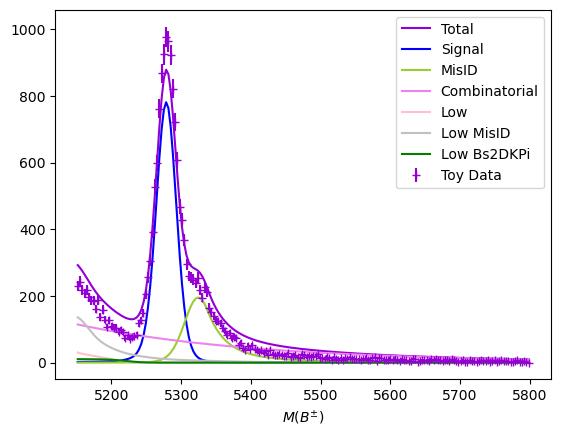

In [22]:
fig, ax = plt.subplots()
plotOn(data=Bu_M, var=[], decay='b2dk_DD',  ax=ax, nbins=200)



- If we would like to fit yields, the extened maximum likelihood fit is performed. The fitted result are not that stable however.
- For the former MD analysis, they are fixed yields fixed pdf and do the fits on $s_{\pm}$